In [2]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from utils.model import predict, load_model, Metrics, save_model, lgb_booster_to_model, load_final_model, save_final_model, load_final_model

SEED = 42

In [20]:
from utils.pipeline import Pipeline, PipelineStep

from steps.set_missings import set_missings, drop_fraud
from utils.helpers import reduce_mem_usage
from steps.load_data import load_train_data, load_test_data
from steps.feature_selection import feature_selection
from steps.dpi_features import generate_test_dpi_feature, generate_train_dpi_feature
from steps.bnum_features import generate_test_bnum_feature, generate_train_bnum_feature
from steps.fe_features import generate_test_fe_feature, generate_train_fe_feature


def remove_abon_id(df):
    return df.drop("abon_id", axis=1)


transform_train_pipeline = Pipeline(
    "TRANSFORM_TRAIN",
    [
        # Load data
        PipelineStep(load_train_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_train_fe_feature),
        PipelineStep(generate_train_dpi_feature),
        PipelineStep(generate_train_bnum_feature),
        PipelineStep(drop_fraud),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

transform_test_pipeline = Pipeline(
    "TRANSFORM_TEST",
    [
        # Load data
        PipelineStep(load_test_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_test_fe_feature),
        PipelineStep(generate_test_dpi_feature),
        PipelineStep(generate_test_bnum_feature),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

In [ ]:
train_data = transform_train_pipeline.run()

print("Shape:", train_data.shape)
print("Columns:", train_data.columns)

In [3]:
import pickle

cache_key = "cache/train_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(train_data, f)

with open(cache_key, "rb") as f:
    train_data = pickle.load(f)

In [ ]:
test_data = transform_test_pipeline.run()

print("Shape:", test_data.shape)
print("Columns:", test_data.columns)

In [4]:
cache_key = "cache/test_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(test_data, f)

with open(cache_key, "rb") as f:
    test_data = pickle.load(f)

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


def oversampling(train_data):
    train_x = train_data.drop(columns="target")
    train_y = train_data.target

    not_churn_data_count = train_data[train_data.target == 0].shape[0]

    not_churn_count_strategy = int(not_churn_data_count * 0.6)
    churn_count_strategy = int(not_churn_data_count * 0.6)

    rus = RandomUnderSampler(random_state=SEED, sampling_strategy={0: not_churn_count_strategy})
    train_x, train_y = rus.fit_resample(train_x, train_y)

    smote = SMOTE(random_state=SEED, sampling_strategy={0: not_churn_count_strategy, 1: churn_count_strategy})
    resampled_x, resampled_y = smote.fit_resample(train_x, train_y)

    resampled_x, val_x, resampled_y, val_y = train_test_split(resampled_x, resampled_y, test_size=0.1, random_state=SEED)

    return resampled_x, resampled_y, val_x, val_y

resampled_x, resampled_y, val_x, val_y = oversampling(train_data)

In [ ]:
model_params = {
    "random_state": 42,
    "seed": 42,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 8.916226764803635,
    "lambda_l2": 9.574590549401839,
    "learning_rate": 0.07518766667831955,
    "num_leaves": 85,
    "feature_fraction": 0.3888218905277871,
    "max_depth": 15,
    "early_stopping_rounds": 100,
}

In [51]:
dtrain = lgb.Dataset(resampled_x, label=resampled_y)
dvalid = lgb.Dataset(val_x, label=val_y, reference=dtrain)

model = lgb.train(model_params, dtrain, valid_sets=[dvalid])

In [52]:
model_params.pop("early_stopping_rounds")

model_cls = lgb.LGBMClassifier(**model_params)

model_cls = model_cls.fit(resampled_x, resampled_y)

In [55]:
train_X = train_data[resampled_x.columns]
train_y_true = train_data.target

train_y_pred_proba = model_cls.booster_.predict(train_X)
threshold = 0.5
train_y_pred = (train_y_pred_proba >= threshold).astype(int)

Metrics().call(train_y_true, train_y_pred, train_y_pred_proba)

print("Columns count ", len(resampled_x.columns))


Metrics
AUC: 0.932
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97    140413
         1.0       0.65      0.48      0.55      9585

    accuracy                           0.95    149998
   macro avg       0.81      0.73      0.76    149998
weighted avg       0.94      0.95      0.95    149998

Columns count  612


In [56]:
test_X = test_data[resampled_x.columns]
test_y_true = test_data.target

test_y_pred_proba = model_cls.booster_.predict(test_X)
threshold = 0.5
test_y_pred = (test_y_pred_proba >= threshold).astype(int)

Metrics().call(test_y_true, test_y_pred, test_y_pred_proba)

print("model_cls.booster_Columns count ", len(resampled_x.columns))


Metrics
AUC: 0.898
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    140597
         1.0       0.59      0.43      0.49      9403

    accuracy                           0.95    150000
   macro avg       0.77      0.70      0.73    150000
weighted avg       0.94      0.95      0.94    150000

model_cls.booster_Columns count  612


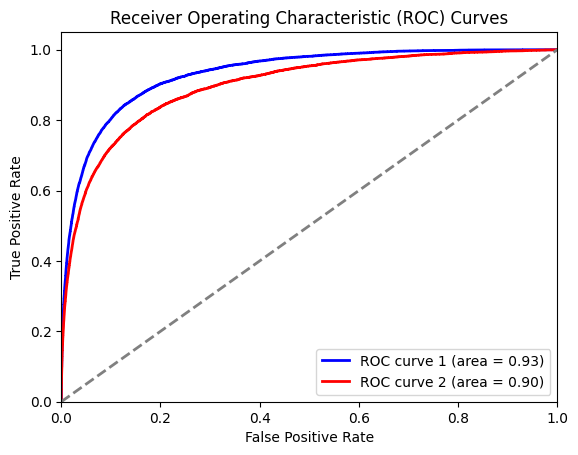

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(y_true1, y_pred1, y_true2, y_pred2):
    # Обчислення ROC AUC та ROC кривих для першого набору даних
    fpr1, tpr1, _ = roc_curve(y_true1, y_pred1)
    roc_auc1 = auc(fpr1, tpr1)

    # Обчислення ROC AUC та ROC кривих для другого набору даних
    fpr2, tpr2, _ = roc_curve(y_true2, y_pred2)
    roc_auc2 = auc(fpr2, tpr2)

    # Побудова графіків
    plt.figure()
    plt.plot(fpr1, tpr1, color="blue", lw=2, label=f"ROC curve 1 (area = {roc_auc1:.2f})")
    plt.plot(fpr2, tpr2, color="red", lw=2, label=f"ROC curve 2 (area = {roc_auc2:.2f})")
    plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(train_y_true, train_y_pred_proba, test_y_true, test_y_pred_proba)

In [92]:
# model_params.pop("early_stopping_rounds")

model_cls = lgb.LGBMClassifier(**model_params)

model_cls = model_cls.fit(val_x, val_y, init_model=model)

In [96]:
X = train_data[resampled_x.columns]
y_true = train_data.target

y_pred_proba = model_cls.booster_.predict(X)
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)

Metrics().call(y_true, y_pred, y_pred_proba)

print("Columns count ", len(X.columns))


Metrics
AUC: 0.966
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    140413
         1.0       0.76      0.62      0.68      9585

    accuracy                           0.96    149998
   macro avg       0.87      0.80      0.83    149998
weighted avg       0.96      0.96      0.96    149998

Columns count  612


In [29]:
save_final_model(model_cls, "BEST_LightGbmV2_pipeline_p061_r043_090auc", list(resampled_x.columns))

Save BEST_LightGbmV2_pipeline_p061_r043_090auc


'BEST_LightGbmV2_pipeline_p061_r043_090auc'